In [73]:
# !git clone https://github.com/ylin00/seizurecast
import sys
import numpy as np
import pandas as pd
# sys.path.append('~/github/ids/seizurecast/seizurecast/')
# sys.path.remove('/Users/yanxlin/github/ids')
# sys.path.pop()
# sys.path.append('..')

In [74]:
import pandas as pd
from seizurecast.features.to_sql import SQLengine
from seizurecast.models.par import LABEL_BKG, LABEL_PRE, LABEL_SEZ

def setlabel(pres, post, len_pos=300, len_pre=300, sec_gap=600):
  """convert pres and post timestamps to background and preseizure labels"""
  y = []
  for _, (pres, post) in enumerate(zip(pres, post)):
    if post > len_pos and pres > sec_gap + len_pre:
      y.append(LABEL_BKG)
    elif post > len_pos and pres > sec_gap:
      y.append(LABEL_PRE)
    else:
      y.append(LABEL_SEZ)
  return y

# Explore the table used in this notebook

## training set of 256 Hz 

In [90]:
dataset = pd.read_sql('select * from train256hz_01 limit 100000', SQLengine)

In [91]:
dataset = dataset\
.assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=300, sec_gap=600))
print(dataset.groupby('label').size())
dataset.head()

label
bckg    84825
pres      623
seiz    14552
dtype: int64


,index,sp0,sp1,sp2,sp3,sp4,sp5,sp6,sp7,sp8,...,sp250,sp251,sp252,sp253,sp254,sp255,post,pres,token,label
0,413,-10.871218,-12.623267,-14.401151,-16.163855,-17.873517,-19.496056,-21.001471,-22.363931,-23.561598,...,-2.776354,-2.354457,-1.997178,-1.715267,-1.515321,-1.399782,99999.0,99999,00010480_s013_t013,bckg
1,414,-1.367052,-1.411769,-1.525414,-1.697131,-1.914591,-2.164825,-2.435088,-2.713708,-2.990681,...,-4.577897,-4.756531,-4.750707,-4.574689,-4.252237,-3.814659,99999.0,99999,00010480_s013_t013,bckg
2,415,-3.298212,-2.741254,-2.181474,-1.653326,-1.185699,-0.799956,-0.508660,-0.315120,-0.213599,...,1.296760,0.466979,-0.464391,-1.461698,-2.482462,-3.479945,99999.0,99999,00010480_s013_t013,bckg
3,416,-4.405966,-5.213916,-5.861904,-6.315718,-6.551238,-6.556087,-6.330548,-5.887771,-5.253085,...,-5.407775,-5.748930,-5.756754,-5.428141,-4.776565,-3.830390,99999.0,99999,00010480_s013_t013,bckg
4,417,-2.630324,-1.226355,0.325542,1.966814,3.639703,5.290374,6.871485,8.344040,9.678628,...,-4.521566,-4.875810,-5.146501,-5.315189,-5.367752,-5.295196,99999.0,99999,00010480_s013_t013,bckg


## Patient directory

In [ ]:
pd.read_sql("select * from directory limit 10", SQLengine).head()

,index,path0,path1,path2,path3,path4,path5,path6,train_test,tcp_type,patient_group,patient,session,token,token_path
0,0,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t008,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
1,1,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t009,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
2,2,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t001,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
3,3,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t000,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...
4,4,,Users,yanxlin,github,ids,tusz_1_5_2,edf,train,03_tcp_ar_a,104,00010418,s018_2014_06_01,00010418_s018_t002,/Users/yanxlin/github/ids/tusz_1_5_2/edf/train...


## Labels of seizure events from experts

In [122]:
[pd.read_sql(f"""
select * from seiz_bckg 
where label='{lbl}' and train_test='train'
""", SQLengine).to_sql(f'tmp_{lbl}_train', SQLengine, if_exists='replace') for lbl in ['bckg', 'seiz']]
print(f"""Number of token containing seizures = {pd.read_sql("select count(*) from tmp_seiz_train", SQLengine).to_numpy()[0,0]}""")
print(f"""Else = {pd.read_sql("select count(*) from tmp_bckg_train", SQLengine).to_numpy()[0,0]}""")
pd.read_sql("select * from tmp_seiz_train limit 3", SQLengine).head()

[None, None]

,level_0,index,token,time_start,time_end,label,prob,train_test
0,0,36,00000492_s003_t000,6.2825,35.8875,seiz,1.0,train
1,1,39,00000492_s003_t001,33.1425,53.0000,seiz,1.0,train
2,2,42,00000492_s003_t002,9.7925,29.1250,seiz,1.0,train


# Split Train Test patients

In [191]:
# randomly sample 80/20 on patient level
from sklearn.model_selection import train_test_split
patient_id = np.unique(pd.read_sql("select * from directory where train_test='train' and tcp_type='01_tcp_ar'", SQLengine).loc[:,'patient'])
patient_train, patient_test = train_test_split(patient_id, test_size=0.2, random_state=0)

print(f"Patient ID: {patient_train[0:3]} ..., Train:{patient_train.shape}, Test:{patient_test.shape}")

Patient ID: ['00000577' '00006103' '00007936'] ..., Train:(246,), Test:(62,)


In [201]:
# Create table patient_group, storing patient ID and their train/test association
pd.concat(
    [pd.DataFrame({'patient':patient_train}).assign(train_test='train'),
    pd.DataFrame({'patient':patient_test}).assign(train_test='test')]
          ).to_sql('patient_group', SQLengine, if_exists='replace')

In [212]:
# create table tmp_token_group storing Token and their train/test group
pd.read_sql("""
select A.train_test, B.token
from patient_group A
inner join directory B on A.patient=B.patient;
""",SQLengine).to_sql('tmp_token_group', SQLengine, if_exists='replace')

In [231]:
pd.read_sql("select * from tmp_token_group", SQLengine).groupby('train_test').groups

{'test': Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
             ...
             3533, 3534, 3535, 3536, 3537, 3609, 3610, 3611, 3612, 3613],
            dtype='int64', length=712),
 'train': Int64Index([  34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
             ...
             3676, 3677, 3678, 3679, 3680, 3681, 3682, 3683, 3684, 3685],
            dtype='int64', length=2974)}

In [493]:
# select train dataset
feature_table = 'train256hz_01'
dataset=[]
for i, group in enumerate(['train', 'test']):
  dataset.append(pd.read_sql(f"""
  (
    select *
    from {feature_table} A
    where A.token in (
      select B.token from tmp_token_group B where B.train_test='{group}'
    ) and (
      A.pres<{300+600}
      and 600<A.pres
      and A.post>300
    ) 
    limit 10000
  )

  union

  (
    select *
    from {feature_table} A
    where A.token in (
      select B.token from tmp_token_group B where B.train_test='{group}' 
    ) and (
      900<A.pres
      and A.post>300
    )
    limit 10000
  );
  """, SQLengine))

In [494]:

# dataset[1]\
# .assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=300, sec_gap=600))\
# .groupby(['label'])\
# .groups

# Training

## Data Prep

In [495]:
# Convert dataframe to numpy array
train_X = dataset[0].iloc[:,1:257].to_numpy()[:,:,np.newaxis]  # new feature axis
train_y = dataset[0].iloc[:,257:]\
.assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=300, sec_gap=600))\
.iloc[:,-1:]\
.to_numpy()
test_X = dataset[1].iloc[:,1:257].to_numpy()[:,:,np.newaxis]  # new feature axis
test_y = dataset[1].iloc[:,257:]\
.assign(label = lambda x: setlabel(x.pres, x.post, len_pos=300, len_pre=300, sec_gap=600))\
.iloc[:,-1:]\
.to_numpy()

# binarize
test_y = np.array([int(y==LABEL_PRE) for y in test_y])[:,np.newaxis]
train_y = np.array([int(y==LABEL_PRE) for y in train_y])[:,np.newaxis]

In [496]:
print("data contain a lot of spikes")
np.histogram(train_X[1:1000,:].flatten())
# for features,label in train_ds.batch(1).take(10):
#   print(np.histogram(features.numpy().flatten()))
  # plt.hist(label.numpy().flatten(), bins = 101)


data contain a lot of spikes


(array([     6,     25,    153,   1393,   5267, 239640,   5736,   2940,
           529,     55]),
 array([-1177.70724208,  -971.20343269,  -764.6996233 ,  -558.19581391,
         -351.69200452,  -145.18819512,    61.31561427,   267.81942366,
          474.32323305,   680.82704244,   887.33085184]))

(11660, 256, 1)
(array([     7,     19,     25,    150,   1394, 252278,   1625,    181,
           49,     16]), array([-42.80249951, -34.9881468 , -27.1737941 , -19.35944139,
       -11.54508868,  -3.73073597,   4.08361674,  11.89796944,
        19.71232215,  27.52667486,  35.34102757]))


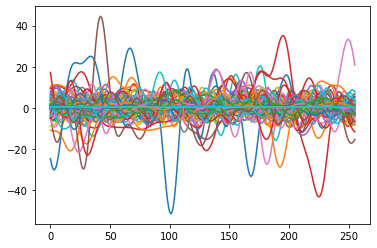

In [507]:
def get_median_filtered(signal, threshold=100):
  """By Bugra"""
  signal = signal.copy()
  difference = np.abs(signal - np.median(signal))
  median_difference = np.median(difference)
  if median_difference == 0:
      s = 0
  else:
      s = difference / float(median_difference)
  mask = s > threshold
  signal[mask] = np.median(signal)
  # if over 10% of data are spikes. return zeros
  if type(mask) is not bool and np.sum(mask) > 0.1 * len(mask):
    return np.zeros(signal.shape)
  return signal

train_X = np.array([get_median_filtered(signal, 8) for signal in train_X])
test_X = np.array([get_median_filtered(signal, 8) for signal in test_X])

np.random.seed(0)
for signal in train_X[np.random.choice(train_X.shape[0], 1000, replace=False),:]:
  plt.plot(signal)

print(train_X.shape)
print(np.histogram(train_X[1:1000,:].flatten()))

After removing spikes, the majority of the features are within a range of -20 to 30 (micro Vol). Let's scale them by 1/50 and normalize them.

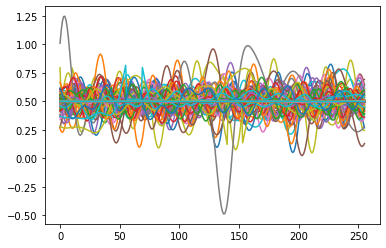

In [508]:
train_X = np.array([0.5 + (signal-np.mean(signal))/50 for signal in train_X ])
test_X = np.array([0.5 + (signal-np.mean(signal))/50 for signal in test_X ])
for signal in train_X[np.random.choice(train_X.shape[0], 1000, replace=False),:]:
  plt.plot(signal)

### Drop out weak channels 

In [509]:
masks = [i for i, signal in enumerate(train_X) if np.sum(np.abs(signal))>1e-3]
train_X = train_X[masks, :, :]
train_y = train_y[masks, :]
masks = [i for i, signal in enumerate(test_X) if np.sum(np.abs(signal))>1e-3]
test_X = test_X[masks, :, :]
test_y = test_y[masks, :]

In [510]:
print("X shape = (samples, timesteps, nfeatures)")
print("y shape = (samples, nfeatures)")
print(f"shape trainX:{train_X.shape}")
print(f"shape trainy:{train_y.shape}")
print(f"shape testX:{test_X.shape}")
print(f"shape testy:{test_y.shape}")

X shape = (samples, timesteps, nfeatures)
y shape = (samples, nfeatures)
shape trainX:(11660, 256, 1)
shape trainy:(11660, 1)
shape testX:(10149, 256, 1)
shape testy:(10149, 1)


In [511]:
pd.DataFrame({
    'train': pd.Series(train_y.squeeze()).value_counts(),
    'test': pd.Series(test_y.squeeze()).value_counts()
})

,train,test
0,10000,10000
1,1660,149


## Modeling

In [512]:
# Shuffling dataset
def unison_shuffled_copies(a, b):
  assert len(a) == len(b)
  p = np.random.permutation(len(a))
  return a[p], b[p]
np.random.seed(0)
train_X, train_y = unison_shuffled_copies(train_X, train_y)
test_X, test_y = unison_shuffled_copies(test_X, test_y)

tf.Tensor([0], shape=(1,), dtype=int64)


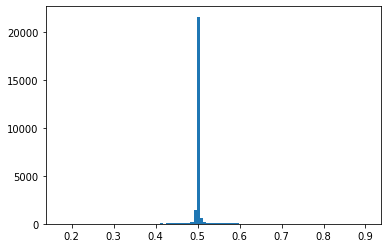

In [513]:
import tensorflow as tf
import matplotlib.pyplot as plt

def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:],1)
  return features, label

# Packed dataset
BATCHSIZE = 100
train_ds = tf.data.Dataset.from_tensor_slices((train_X.squeeze(), train_y.squeeze())).batch(BATCHSIZE).map(pack_row).unbatch()
test_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y)).batch(BATCHSIZE).map(pack_row).unbatch()

for features,label in train_ds.batch(100).take(1):
  print(features[0])
  plt.hist(label.numpy().flatten(), bins = 101)


Check data balance

In [514]:
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Dropout, Bidirectional

model = Sequential()
model.add(Input(shape=(256,1), name='Input'))
model.add(Bidirectional(LSTM(10, kernel_regularizer="l2", name='LSTM-1')))
model.add(Dropout(0.25, name='Dropout'))
model.add(Dense(1, activation='softmax', name='Dense'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

print('start training')
model.fit(
        train_X, 
        train_y,
        validation_split=0.2, 
        batch_size=500, 
        epochs=3,
        verbose=1
    )

Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 20)                960       
_________________________________________________________________
Dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
Dense (Dense)                (None, 1)                 21        
Total params: 981
Trainable params: 981
Non-trainable params: 0
_________________________________________________________________
None
start training
Epoch 1/3
19/19 [==============================] - 6s 335ms/step - loss: 13.1013 - accuracy: 0.1432 - val_loss: 13.1637 - val_accuracy: 0.1389
Epoch 2/3
19/19 [==============================] - 6s 307ms/step - loss: 13.0960 - accuracy: 0.1432 - val_loss: 13.1588 - val_accuracy: 0.1389
Epoch 3/3
19/19 [==============================] - 8s 416ms/step - loss: 13.091